# Step 1: mechanics with Euler-Lagrange

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from numpy import logical_and as npand
from numpy import logical_or as npor

In [2]:
from sympy import (symbols, pi, I, E, cos, sin, exp, tan, simplify, expand, factor, collect,
                   apart, cancel, expand_trig, diff, Derivative, Function, integrate, limit,
                   series, Eq, solve, dsolve, Matrix, N, preorder_traversal, Float, solve_linear_system,
                   eye, zeros, lambdify)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting

In [3]:
init_vprinting()

In [4]:
m0, m1, l0, l1, t, g = symbols('m_0 m_1 l_0 l_1 t g')

In [5]:
the1, the2 = dynamicsymbols('theta_1 theta_2')
the1, the2

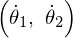

In [6]:
thedot1 = the1.diff(t)
thedot2 = the2.diff(t)
thedot1, thedot2

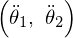

In [7]:
thedotdot1 = thedot1.diff(t)
thedotdot2 = thedot2.diff(t)
thedotdot1, thedotdot2

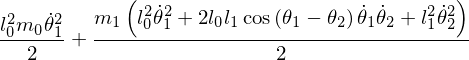

In [8]:
T = m0*l0**2*thedot1**2/2 + m1*(l0**2*thedot1**2 + l1**2*thedot2**2 + 2*l0*l1*thedot1*thedot2*cos(the2-the1))/2
T

In [9]:
U = -m0*g*cos(the1)*l0 - m1*g*(l0*cos(the1)+l1*cos(the2))
U

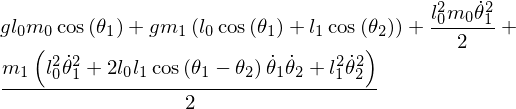

In [10]:
L = T-U
L

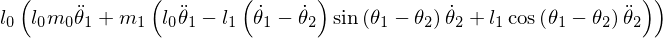

In [11]:
L.diff(thedot1).simplify().diff(t).simplify()

In [12]:
L.diff(the1)

In [13]:
def lagrange(expr, var):
    vardot = var.diff(t)
    lag1 = expr.diff(vardot).simplify().diff(t).simplify()
    lag2 = expr.diff(var).simplify()
    lag = lag1-lag2
    return lag.simplify()

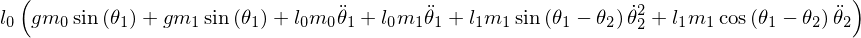

In [14]:
l_expr_1 = lagrange(L, the1)
l_expr_1

## discretization:

$$x_{n+1} = x_n + dt x'$$
$$x' = \frac{x_{n+1}-x_n}{dt}$$

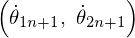

In [15]:
thedot1_1 = dynamicsymbols('theta_1n+1').diff(t)
thedot2_1 = dynamicsymbols('theta_2n+1').diff(t)
thedot1_1, thedot2_1

In [26]:
dt = symbols('dt')

In [16]:
def lagrange_disc(expr, var, params):
    vardot = var.diff(t)
    vardotdot = vardot.diff(t)
    name = var.name
    lag1 = expr.diff(vardot).simplify().diff(t).simplify()
    lag2 = expr.diff(var).simplify()
    lag = (lag1-lag2).simplify()
    vardot_1 = dynamicsymbols(name+'n+1').diff(t)
    dt = symbols('dt')
    lag = lag.subs(vardotdot, (vardot_1-vardot)/dt)
    for para in params:
        parname = para.name
        pardot = para.diff(t)
        pardotdot = pardot.diff(t)
        pardot_1 = dynamicsymbols(parname+'n+1').diff(t)
        lag = lag.subs(pardotdot, (pardot_1-pardot)/dt)
    return lag.simplify()

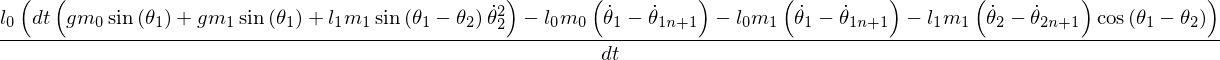

In [45]:
l_expr_1 = lagrange_disc(L, the1, [the2])
l_expr_1

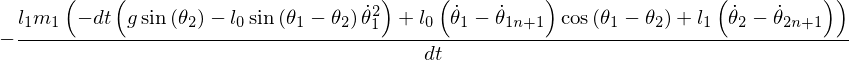

In [28]:
l_expr_2 = lagrange_disc(L, the2, [the1])
l_expr_2

# Step 2: conversion?

In [19]:
import casadi as cas

In [35]:
def sympy2casadi(sympy_expr,sympy_var,casadi_var):
    #import casadi
    assert casadi_var.is_vector()
    if casadi_var.shape[1]>1:
        casadi_var = casadi_var.T
    casadi_var = cas.vertsplit(casadi_var)
    from sympy.utilities.lambdify import lambdify

    mapping = {'ImmutableDenseMatrix': cas.blockcat,
             'MutableDenseMatrix': cas.blockcat,
             'Abs':cas.fabs
            }
    f = lambdify(sympy_var,sympy_expr,modules=[mapping, cas])
    print(casadi_var)
    return f(*casadi_var)

In [51]:
l_sy_vars = [m0, m1, l0, l1, t, dt, g, the1, the2, thedot1, thedot2, thedot1_1, thedot2_1]

In [57]:
x = cas.SX.sym('x', 4)
x_n = cas.SX.sym('x_n', 4)
u = cas.SX.sym('u', 2)
m = cas.SX.sym('m', 2)
l = cas.SX.sym('l', 2)
T = cas.SX.sym("t")
Dt = cas.SX.sym("dt")
G = cas.SX.sym("g")

In [58]:
l_cas_vars = cas.vertcat(m[0],m[1],l[0],l[1],T,Dt,G,x[0],x[1],x[2],x[3],x_n[2], x_n[3])

In [59]:
L_expr_1 = sympy2casadi(l_expr_1, l_sy_vars, l_cas_vars)
L_expr_1

[SX(m_0), SX(m_1), SX(l_0), SX(l_1), SX(t), SX(dt), SX(g), SX(x_0), SX(x_1), SX(x_2), SX(x_3), SX(x_n_2), SX(x_n_3)]


SX(((l_0*((((dt*((((g*m_0)*sin(x_0))-(((sq(x_3)*l_1)*m_1)*sin((x_1-x_0))))+((g*m_1)*sin(x_0))))-((l_0*m_0)*(x_2-x_n_2)))-((l_0*m_1)*(x_2-x_n_2)))-(((l_1*m_1)*(x_3-x_n_3))*cos((x_1-x_0)))))/dt))

In [60]:
L_expr_2 = sympy2casadi(l_expr_2, l_sy_vars, l_cas_vars)
L_expr_2

[SX(m_0), SX(m_1), SX(l_0), SX(l_1), SX(t), SX(dt), SX(g), SX(x_0), SX(x_1), SX(x_2), SX(x_3), SX(x_n_2), SX(x_n_3)]


SX((-(((l_1*m_1)*((((l_0*(x_2-x_n_2))*cos((x_1-x_0)))-(dt*(((sq(x_2)*l_0)*sin((x_1-x_0)))+(g*sin(x_1)))))+(l_1*(x_3-x_n_3))))/dt)))

In [61]:
step_rest_1 = cas.Function('Step_rest_1', [x, x_n, u, Dt, m, l, G], [L_expr_1-u[0]])

In [62]:
step_rest_2 = cas.Function('Step_rest_2', [x, x_n, u, Dt, m, l, G], [L_expr_1-u[1]])

In [63]:
N = 200

In [65]:
opti = cas.Opti()
opti.solver('ipopt')

In [ ]:
X = opti.variable(N+1,4)
U = opti.variable(N,2)
T = opti.variable()
u_m = opti.parameter()